## ACCRE


### Questions from Eric:

### 1) What groups are best optimizing their memory usage in terms of percent of actual memory used vs. memory requested for the job? What is the average percent for each group?

Note: 
    When Eric says "group" is he referring to "research groups" (which could be indicated by one or more account IDs), job groups (job IDs in an array), or partition groups?
    

### 2) Optimizing memory is more important for longer running jobs than shorter running jobs, as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group? 
Note: Recall that high throughput computing (HTC) is focused on the use of multiple resources over long periods of time.

### 3) We are concerned with potentially unreliable notes which are not being detected by routine monitoring.  Of the jobs that failed, do any nodes show up unusually often?

Tip: Ignore debug partition. Look for failed jobs.

Note: Consider his use of "unusually often"

### 4) The CMS collaboration submits jobs that will run internal diagnostics and intentionally end early in 30 minutes. How often is this happening? (ie: what percent of jobs are CMS jobs) And does it happen on the same nodes repeatedly?

Tip: Check both 'production' and 'nogpfs' partitions. Look for commonly failing nodes and compare with other failed jobs. 

Note: 
    Filter df with below parameters:
        - Only production and nogpfs partitions 
        - State = 'cancelled'
        - Usedtime = 30 minutes
    Count number of unique job ids fall into this criteria
    Compare to total number of unique job ids

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
import re

## Column renames ---> 1) nodelist, 2)nodelist nonproduction

#### Read in the data. The Nodes column triggers errors because several values are spread out over multiple other columns to the right.

In [2]:
#accre = pd.read_csv('../data/accre-jobs-2020.csv',names=['JOBID', 'ACCOUNT', 'USER', 'REQMEM', 'USEDMEM', 'REQTIME', 'USEDTIME',
       #'NODES', 'CPUS', 'PARTITION', 'EXITCODE', 'STATE', 'NODELIST'])

#MP's previous suggestion for how to read in the file by identifying which columns to include. Resulted in adding additional row with column names as row values

In [3]:
accre = pd.read_csv('../data/accre-jobs-2020.csv', nrows=9000, error_bad_lines=False)

b'Skipping line 3461: expected 13 fields, saw 15\nSkipping line 3462: expected 13 fields, saw 16\nSkipping line 3465: expected 13 fields, saw 15\nSkipping line 3468: expected 13 fields, saw 16\nSkipping line 3472: expected 13 fields, saw 15\nSkipping line 3476: expected 13 fields, saw 16\nSkipping line 3479: expected 13 fields, saw 14\nSkipping line 3482: expected 13 fields, saw 14\nSkipping line 3486: expected 13 fields, saw 14\nSkipping line 3490: expected 13 fields, saw 14\nSkipping line 3494: expected 13 fields, saw 14\nSkipping line 3495: expected 13 fields, saw 16\nSkipping line 3497: expected 13 fields, saw 14\nSkipping line 3498: expected 13 fields, saw 14\nSkipping line 3499: expected 13 fields, saw 14\nSkipping line 3505: expected 13 fields, saw 14\nSkipping line 3517: expected 13 fields, saw 16\nSkipping line 3526: expected 13 fields, saw 15\nSkipping line 3528: expected 13 fields, saw 15\nSkipping line 3529: expected 13 fields, saw 15\nSkipping line 3530: expected 13 fields

In [4]:
accre.head()

JOBID  ACCOUNT      USER    REQMEM    USEDMEM      REQTIME     USEDTIME  \
0  15925210  treviso  arabella  122880Mn  65973.49M  13-18:00:00  13-18:00:28   
1  15861126  treviso  arabella  122880Mn  67181.12M  13-18:00:00  12-14:50:56   
2  15861125  treviso  arabella  122880Mn  69111.86M  13-18:00:00  13-18:00:20   
3  16251645  treviso  arabella  122880Mn  65317.33M  13-18:00:00  12-03:50:32   
4  16251646  treviso  arabella  122880Mn  65876.11M  13-18:00:00  13-18:00:03   

   NODES  CPUS   PARTITION EXITCODE      STATE NODELIST  
0      1    24  production      0:0  COMPLETED   cn1531  
1      1    24  production      0:0  COMPLETED   cn1441  
2      1    24  production      0:0  COMPLETED   cn1464  
3      1    24  production      0:0  COMPLETED   cn1473  
4      1    24  production      0:0  COMPLETED   cn1440

In [5]:
#examining range of rows during group discussion
#accre.iloc[3449:3471,:]

In [6]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   JOBID      9000 non-null   object
 1   ACCOUNT    9000 non-null   object
 2   USER       9000 non-null   object
 3   REQMEM     9000 non-null   object
 4   USEDMEM    9000 non-null   object
 5   REQTIME    9000 non-null   object
 6   USEDTIME   9000 non-null   object
 7   NODES      9000 non-null   int64 
 8   CPUS       9000 non-null   int64 
 9   PARTITION  9000 non-null   object
 10  EXITCODE   9000 non-null   object
 11  STATE      9000 non-null   object
 12  NODELIST   9000 non-null   object
dtypes: int64(2), object(11)
memory usage: 914.2+ KB


### Convert column names to lowercase

In [7]:
#make column names lowercase, per group discussion
accre.columns = accre.columns.str.lower()

In [8]:
accre.usedtime.sort_values()

8570      00:00:06
8437      00:00:08
8438      00:00:10
8358      00:00:12
8716      00:00:12
           ...    
683     8-08:00:29
691     8-08:00:29
680     8-08:00:31
4123    8-13:11:39
4122    9-13:20:14
Name: usedtime, Length: 9000, dtype: object

In [9]:
accre.usedtime.describe()

count         9000
unique        6398
top       00:00:39
freq            85
Name: usedtime, dtype: object

### Job time is in a format of either d-hh:mm:ss or hh:mm:ss. Convert to seconds.

In [10]:
#Convert the times into seconds

def convert_time_to_seconds(time):
    """Return an integer value of the time converted into seconds."""
    
    #Identify values not formatted as d-hh:mm:ss. Fill in the hour value by appending '0-' on the left of the string. 
    #This will make all our strings cleanly parse into an equal number of substrings.
    
    if len(time) <9:
        time = "0-" + time
    else: time
    
    #Use regex to select either '-' OR ':' as delimiter for split. The resulting substring list is ordered as [days, hours, minutes, seconds]
    #Cast the list of substrings to numeric, turning it into an array. Cleaner to do it here than for each individual substring
    time = pd.to_numeric(re.split('[-|:]',time))

    #Add the product of each unit and its multiplier to get the total time in seconds
    
    time_in_seconds = time[-4]*86400 + time[-3]*3600 + time[-2]*60 + time[-1]
    
    return time_in_seconds

In [11]:
#Change existing time columns to time in seconds.
accre['reqtime'] = accre['reqtime'].apply(convert_time_to_seconds)
accre['usedtime'] = accre['usedtime'].apply(convert_time_to_seconds)

In [12]:
#Create new columns to reflect difference between requested time and used time.
#Values - in seconds
accre['time_diff'] = accre['reqtime'] - accre['usedtime']
#Percent
accre['time_pct_used'] = accre['usedtime'] / accre['reqtime'] * 100

In [13]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   jobid          9000 non-null   object 
 1   account        9000 non-null   object 
 2   user           9000 non-null   object 
 3   reqmem         9000 non-null   object 
 4   usedmem        9000 non-null   object 
 5   reqtime        9000 non-null   int64  
 6   usedtime       9000 non-null   int64  
 7   nodes          9000 non-null   int64  
 8   cpus           9000 non-null   int64  
 9   partition      9000 non-null   object 
 10  exitcode       9000 non-null   object 
 11  state          9000 non-null   object 
 12  nodelist       9000 non-null   object 
 13  time_diff      9000 non-null   int64  
 14  time_diff_pct  9000 non-null   float64
dtypes: float64(1), int64(5), object(9)
memory usage: 1.0+ MB


In [14]:
accre.head()

jobid  account      user    reqmem    usedmem  reqtime  usedtime  nodes  \
0  15925210  treviso  arabella  122880Mn  65973.49M  1188000   1188028      1   
1  15861126  treviso  arabella  122880Mn  67181.12M  1188000   1090256      1   
2  15861125  treviso  arabella  122880Mn  69111.86M  1188000   1188020      1   
3  16251645  treviso  arabella  122880Mn  65317.33M  1188000   1050632      1   
4  16251646  treviso  arabella  122880Mn  65876.11M  1188000   1188003      1   

   cpus   partition exitcode      state nodelist  time_diff  time_diff_pct  
0    24  production      0:0  COMPLETED   cn1531        -28     100.002357  
1    24  production      0:0  COMPLETED   cn1441      97744      91.772391  
2    24  production      0:0  COMPLETED   cn1464        -20     100.001684  
3    24  production      0:0  COMPLETED   cn1473     137368      88.437037  
4    24  production      0:0  COMPLETED   cn1440         -3     100.000253

In [15]:
accre.time_diff.value_counts()

431961    85
431965    65
431962    63
431969    57
431960    53
          ..
182676     1
27553      1
358810     1
22950      1
106336     1
Name: time_diff, Length: 6375, dtype: int64

In [16]:
accre.time_diff.unique()

array([   -28,  97744,    -20, ..., 161371,  25641, 120576])

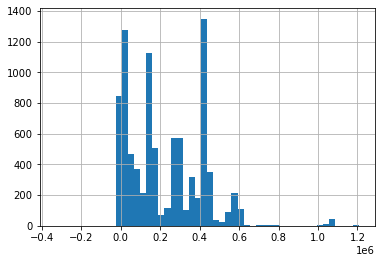

In [17]:
accre.time_diff.hist(bins=50)

### Exitcode has two values. 0:0 indicates a successful job. Split into two columns.
Nonzero on the right - issue with the job itself or node (eg: out of memory, node failure, job cancelled)
Nonzero on the left - issue with the user's software

In [18]:
accre.exitcode.value_counts()

0:0     8995
0:15       2
1:0        2
0:6        1
Name: exitcode, dtype: int64

In [19]:
accre[['exitcode_user', 'exitcode_node']] = accre['exitcode'].str.split(':', expand=True).astype(int)

In [20]:
accre.sample(5)

jobid      account       user   reqmem   usedmem  reqtime  \
377   16849298_2532  minnewashta  jenniffer  16384Mn   586.11M   252000   
7617       17092038  cms_lowprio   cmslocal  28000Mn  6621.31M   172800   
1588   17021284_549        regal     debbra  16384Mn  1229.14M   540000   
160   16849298_2188  minnewashta  jenniffer  16384Mn   618.46M   252000   
5822       17074003       endive    bennett   8192Mn  2815.68M   432000   

      usedtime  nodes  cpus   partition exitcode      state nodelist  \
377     223138      1     1  production      0:0  COMPLETED    cn449   
7617     16176      1     4  production      0:0  COMPLETED   cn1509   
1588    540013      1     1  production      0:0  COMPLETED   cn1124   
160     235514      1     1  production      0:0  COMPLETED   cn1390   
5822        67      1     1      turing      0:0  COMPLETED  gpu0040   

      time_diff  time_diff_pct  exitcode_user  exitcode_node  
377       28862      88.546825              0              0  
7617     156624       9.361111              0              0  
1588        -13     100.002407              0              0  
160       16486      93.457937              0              0  
5822     431933       0.015509              0              0

### Memory is reported in terms of Megabytes per node (Mc) or Megabytes per core (Mc), this needs to be uniformly converted to Megabytes per core by dividing by the number of cores per node in a job. 

Note: CPUS column includes total number of CPU cores allocated to a job (even for multi-node jobs). 
    WHEN reqmem column includes Mn AND in the entire usemem column
    Memory (CPUs / Nodes)


In [21]:
#Separate digits from suffixes Mn and Mc. Save numbers to reqmemory column and suffixes to core_node column.
accre[['reqmemory', 'core_node']] = accre['reqmem'].str.split('M', expand=True)
accre['reqmemory'] = accre['reqmemory'].astype(int)

In [22]:
#Convert requested memory column to 'by core'
accre['reqmemory'] = np.where(
    accre['core_node']=='n', accre['reqmemory'] / accre['cpus'] / accre['nodes'], 
accre['reqmemory']
)

In [23]:
#Remove M suffix in requested memory column. Save as float and convert to memory per core
accre['usedmemory'] = accre['usedmem'].str.replace(r'M*', '').astype(float)
accre['usedmemory'] = round(accre['usedmemory'] / accre['cpus'] / accre['nodes'], 1)

In [24]:
#Calculate difference in requested time vs used time. Save to new columns for actual values and percentages
#Values
accre['mem_diff'] = accre['reqmemory'] - accre['usedmemory']
#Percent
accre['mem_pct_used'] = accre['usedmemory'] / accre['reqmemory'] * 100

In [25]:
accre.sample(10)

jobid account      user   reqmem   usedmem  reqtime  usedtime  \
7886   17092515_24     cep     codie   4096Mc  1715.27M   604800    163444   
5851      17074040     cms  cmspilot  28000Mn  9808.25M   172800    169948   
6955    17089300_6     cep       hoy   1024Mc   517.79M    90000     78999   
5326      17073505  endive   bennett   8192Mn     0.23M   432000        39   
3862   17052677_15  carrot     codie   4096Mc  1730.92M   604800    167200   
5794      17073974  endive   bennett   8192Mn         0   432000        28   
6240   17075430_46     cep     codie   4096Mc  1723.81M   604800    171976   
3684  17051372_171     cep     sasha   1024Mc   375.77M    90000     55794   
2999  17045075_708  winged    lavona   4096Mn   229.59M   345600     86894   
7149      17090228     cms  cmslocal  28000Mn  6619.43M   172800     24227   

      nodes  cpus   partition  ... nodelist time_diff time_diff_pct  \
7886      1     1  production  ...   cn1335    441356     27.024471   
5851      1     4  production  ...    cn357      2852     98.349537   
6955      1     1  production  ...   cn1266     11001     87.776667   
5326      1     1      turing  ...  gpu0035    431961      0.009028   
3862      1     1  production  ...   cn1438    437600     27.645503   
5794      1     1      turing  ...  gpu0038    431972      0.006481   
6240      1     1  production  ...   cn1475    432824     28.435185   
3684      1     1  production  ...   cn1082     34206     61.993333   
2999      1     1  production  ...    cn306    258706     25.142940   
7149      1     4  production  ...    cn306    148573     14.020255   

      exitcode_user  exitcode_node  reqmemory  core_node  usedmemory mem_diff  \
7886              0              0     4096.0          c      1715.3   2380.7   
5851              0              0     7000.0          n      2452.1   4547.9   
6955              0              0     1024.0          c       517.8    506.2   
5326              0              0     8192.0          n         0.2   8191.8   
3862              0              0     4096.0          c      1730.9   2365.1   
5794              0              0     8192.0          n         0.0   8192.0   
6240              0              0     4096.0          c      1723.8   2372.2   
3684              0              0     1024.0          c       375.8    648.2   
2999              0              0     4096.0          n       229.6   3866.4   
7149              0              0     7000.0          n      1654.9   5345.1   

      mem_diff_pct  
7886     41.877441  
5851     35.030000  
6955     50.566406  
5326      0.002441  
3862     42.258301  
5794      0.000000  
6240     42.084961  
3684     36.699219  
2999      5.605469  
7149     23.641429  

[10 rows x 22 columns]

### If time allows filter out situations with number of nodes is greater than cpus

In [26]:
accre[(accre['nodes'] > 1) &(accre['cpus']== 1)]
#Index 3576 - if CPUs is "total number of CPU cores allocated to the job", then how can one CPU core operate over three nodes?

jobid account     user  reqmem   usedmem  reqtime  usedtime  \
3560  17050901_230  winged  lavonda  4096Mn   638.77M    43200       331   
3570  17050901_244  winged  lavonda  4096Mn  2053.59M    43200     15812   
3573  17050901_247  winged  lavonda  4096Mn   657.07M    43200       310   
3576  17050901_252  winged  lavonda  4096Mn  2067.69M    43200     32038   
3577  17050901_253  winged  lavonda  4096Mn   588.94M    43200       345   
3583  17050901_259  winged  lavonda  4096Mn  1364.63M    43200     43206   
3588  17050901_268  winged  lavonda  4096Mn  2066.19M    43200     43226   

      nodes  cpus   partition  ...       nodelist time_diff time_diff_pct  \
3560      3     1  production  ...  cn[1131-1133]     42869      0.766204   
3570      3     1  production  ...  cn[1094-1096]     27388     36.601852   
3573      3     1  production  ...  cn[1131-1133]     42890      0.717593   
3576      3     1  production  ...  cn[1082-1084]     11162     74.162037   
3577      3     1  production  ...  cn[1086-1088]     42855      0.798611   
3583      3     1  production  ...  cn[1130-1132]        -6    100.013889   
3588      3     1  production  ...  cn[1086-1088]       -26    100.060185   

      exitcode_user  exitcode_node    reqmemory  core_node  usedmemory  \
3560              0              0  1365.333333          n       212.9   
3570              0              0  1365.333333          n       684.5   
3573              0              0  1365.333333          n       219.0   
3576              0              0  1365.333333          n       689.2   
3577              0              0  1365.333333          n       196.3   
3583              0              0  1365.333333          n       454.9   
3588              0              0  1365.333333          n       688.7   

         mem_diff  mem_diff_pct  
3560  1152.433333     15.593262  
3570   680.833333     50.134277  
3573  1146.333333     16.040039  
3576   676.133333     50.478516  
3577  1169.033333     14.377441  
3583   910.433333     33.317871  
3588   676.633333     50.441895  

[7 rows x 22 columns]

In [27]:
#Adjust order of columns in dataframe. 
#Drop original exitcode, reqmem and usedmem columns and the helper core_node column.

accre = accre[['jobid', 'account', 'user','reqmemory','usedmemory', 'mem_diff', 'mem_pct_used', 'reqtime', 'usedtime',
       'time_diff', 'time_pct_used','nodes', 'cpus', 'partition', 'exitcode_user', 'exitcode_node', 'state', 
        'nodelist']]

In [28]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   jobid          9000 non-null   object 
 1   account        9000 non-null   object 
 2   user           9000 non-null   object 
 3   reqmemory      9000 non-null   float64
 4   usedmemory     9000 non-null   float64
 5   mem_diff       8994 non-null   float64
 6   mem_diff_pct   8994 non-null   float64
 7   reqtime        9000 non-null   int64  
 8   usedtime       9000 non-null   int64  
 9   time_diff      9000 non-null   int64  
 10  time_diff_pct  9000 non-null   float64
 11  nodes          9000 non-null   int64  
 12  cpus           9000 non-null   int64  
 13  partition      9000 non-null   object 
 14  exitcode_user  9000 non-null   int64  
 15  exitcode_node  9000 non-null   int64  
 16  state          9000 non-null   object 
 17  nodelist       9000 non-null   object 
dtypes: float

In [29]:
#Code to groupby to find mean of each account
#accre.groupby('account')[['account', 'mem_pct_used']].mean().sort_values('mem_pct_used')

### Remove rows with values other than "production" in the Partition column.
"We really only want to look at the "production" partition so rows with other partitions should be removed"

#### However, we probably want to do this AFTER cleaning all the data. One of Eric's questions requests examining data where partition = 'nogpfs'

In [30]:
#Check the distribution of partition values
accre.partition.value_counts(normalize=True)

production        0.808222
turing            0.139222
nogpfs            0.048333
sam               0.001333
debug             0.001111
pascal            0.000889
cgw-cqs1          0.000222
maxwell           0.000222
cgw-capra1        0.000222
cgw-tbi01         0.000111
cgw-dougherty1    0.000111
Name: partition, dtype: float64

In [31]:
#Include everything BUT production data and save as new df.
accre_nonprod = accre[accre['partition']!='production'].reset_index(drop = True)
accre_nonprod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   jobid          1726 non-null   object 
 1   account        1726 non-null   object 
 2   user           1726 non-null   object 
 3   reqmemory      1726 non-null   float64
 4   usedmemory     1726 non-null   float64
 5   mem_diff       1720 non-null   float64
 6   mem_diff_pct   1720 non-null   float64
 7   reqtime        1726 non-null   int64  
 8   usedtime       1726 non-null   int64  
 9   time_diff      1726 non-null   int64  
 10  time_diff_pct  1726 non-null   float64
 11  nodes          1726 non-null   int64  
 12  cpus           1726 non-null   int64  
 13  partition      1726 non-null   object 
 14  exitcode_user  1726 non-null   int64  
 15  exitcode_node  1726 non-null   int64  
 16  state          1726 non-null   object 
 17  nodelist       1726 non-null   object 
dtypes: float

In [32]:
accre_nonprod[accre_nonprod['partition']=='nogpfs'].sample(25)

jobid account      user    reqmemory  usedmemory     mem_diff  \
1682  17095168     cms  cmslocal  2734.375000         0.2  2734.175000   
276   17072866     cms  cmspilot  3582.833333      2237.2  1345.633333   
1564  17094541     cms  cmspilot  2734.375000      1372.0  1362.375000   
1424  17089621     cms  cmslocal  2734.375000      1422.5  1311.875000   
1484  17093938     cms  cmslocal  2734.750000      1748.4   986.350000   
39    17051128     cms  cmspilot  4750.875000      3663.5  1087.375000   
265   17072843     cms  cmspilot  3582.833333      2030.2  1552.633333   
1436  17093438     cms  cmslocal  2735.000000         0.0  2735.000000   
1445  17093477     cms  cmslocal  2735.000000         0.2  2734.800000   
251   17072819     cms  cmspilot  2231.000000      1692.8   538.200000   
1581  17094566     cms  cmspilot  2734.375000         0.1  2734.275000   
64    17063628     cms  cmspilot  2734.375000      1525.9  1208.475000   
12    17032916     cms  cmspilot  2734.375000      1466.0  1268.375000   
1481  17093934     cms  cmslocal  2734.375000         0.1  2734.275000   
1513  17094156     cms  cmspilot  3838.833333      1567.7  2271.133333   
1530  17094361     cms  cmslocal  5832.750000         0.0  5832.750000   
1662  17095017     cms  cmslocal  2735.000000      1146.1  1588.900000   
48    17063508     cms  cmspilot  2734.750000      1402.8  1331.950000   
263   17072839     cms  cmspilot  2734.375000      2234.8   499.575000   
1393  17088703     cms  cmspilot  2231.000000      1350.8   880.200000   
1639  17094768     cms  cmslocal  3582.833333         0.2  3582.633333   
1644  17094814     cms  cmslocal  2734.750000      1439.8  1294.950000   
1494  17093953     cms  cmspilot  5832.750000         0.0  5832.750000   
52    17063514     cms  cmspilot  5758.875000      1842.9  3915.975000   
1529  17094359     cms  cmslocal  5832.750000         0.0  5832.750000   

      mem_diff_pct  reqtime  usedtime  time_diff  time_diff_pct  nodes  cpus  \
1682      0.007314   172800      1241     171559       0.718171      1     8   
276      62.442201   172800    169659       3141      98.182292      1    12   
1564     50.176000   172800    165448       7352      95.745370      1     8   
1424     52.022857   172800     25323     147477      14.654514      1     8   
1484     63.932718   172800      3153     169647       1.824653      1     8   
39       77.112111   172800    155588      17212      90.039352      1     8   
265      56.664651   172800    167094       5706      96.697917      1    12   
1436      0.000000   172800      5524     167276       3.196759      1     8   
1445      0.007313   172800      1319     171481       0.763310      1     8   
251      75.876289   172800    165819       6981      95.960069      1     8   
1581      0.003657   172800      1226     171574       0.709491      1     8   
64       55.804343   172800    142499      30301      82.464699      1     8   
12       53.613714   172800    170875       1925      98.885995      1     8   
1481      0.003657   172800      1223     171577       0.707755      1     8   
1513     40.837928   172800    165045       7755      95.512153      1    12   
1530      0.000000   172800        40     172760       0.023148      1    32   
1662     41.904936   172800     27659     145141      16.006366      1     8   
48       51.295365   172800    169376       3424      98.018519      1     8   
263      81.729829   172800    164315       8485      95.089699      1     8   
1393     60.546840   172800    162867       9933      94.251736      1     8   
1639      0.005582   172800       558     172242       0.322917      1    12   
1644     52.648323   172800     28347     144453      16.404514      1     8   
1494      0.000000   172800        35     172765       0.020255      1    32   
52       32.001042   172800    167288       5512      96.810185      1     8   
1529      0.000000   172800        59     172741       0.034144      1    32   

   

In [33]:
#Exclude everything other than production data and use Boolean mask and save accre df back to itself.
accre = accre[accre['partition']=='production'].reset_index(drop = True)
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   jobid          7274 non-null   object 
 1   account        7274 non-null   object 
 2   user           7274 non-null   object 
 3   reqmemory      7274 non-null   float64
 4   usedmemory     7274 non-null   float64
 5   mem_diff       7274 non-null   float64
 6   mem_diff_pct   7274 non-null   float64
 7   reqtime        7274 non-null   int64  
 8   usedtime       7274 non-null   int64  
 9   time_diff      7274 non-null   int64  
 10  time_diff_pct  7274 non-null   float64
 11  nodes          7274 non-null   int64  
 12  cpus           7274 non-null   int64  
 13  partition      7274 non-null   object 
 14  exitcode_user  7274 non-null   int64  
 15  exitcode_node  7274 non-null   int64  
 16  state          7274 non-null   object 
 17  nodelist       7274 non-null   object 
dtypes: float

In [34]:
accre.sample(15)

jobid      account        user  reqmemory  usedmemory  mem_diff  \
4886    17075432_28          cep       codie     4096.0      1715.4    2380.6   
263   16849298_2383  minnewashta   jenniffer    16384.0       581.6   15802.4   
1249   17021284_217        regal      debbra    16384.0       989.0   15395.0   
1246   17021284_214        regal      debbra    16384.0      1230.5   15153.5   
1029    17016721_59     sunburst     darlyne     8192.0      2253.6    5938.4   
4147       17063541          cms    cmspilot     7000.0      3513.7    3486.3   
5588     17089441_7          cep         hoy     1024.0       518.9     505.1   
3036   17045075_781       winged      lavona     4096.0       282.7    3813.3   
3194   17045075_939       winged      lavona     4096.0       225.9    3870.1   
2283       17043147         wood     hillery      600.0       156.7     443.3   
7053       17095380  cms_lowprio    cmspilot     5000.0      1427.9    3572.1   
1454   17021284_423        regal      debbra    16384.0      1033.0   15351.0   
902     17016720_32     sunburst     darlyne     8192.0      2815.5    5376.5   
4719    17075404_32          cep       codie     4096.0      1715.3    2380.7   
4164    17064839_45      pasilla  margaretta    12800.0         7.7   12792.3   

      mem_diff_pct  reqtime  usedtime  time_diff  time_diff_pct  nodes  cpus  \
4886     41.879883   604800    171162     433638      28.300595      1     1   
263       3.549805   252000    131165     120835      52.049603      1     1   
1249      6.036377   540000    189893     350107      35.165370      1     1   
1246      7.510376   540000    197031     342969      36.487222      1     1   
1029     27.509766  1209600    627739     581861      51.896412      1     1   
4147     50.195714   172800    145906      26894      84.436343      1     4   
5588     50.673828    90000     74794      15206      83.104444      1     1   
3036      6.901855   345600     69965     275635      20.244502      1     1   
3194      5.515137   345600     74173     271427      21.462095      1     1   
2283     26.116667   212280    212297        -17     100.008008      1     1   
7053     28.558000   172800     30579     142221      17.696181      1     1   
1454      6.304932   540000    540002         -2     100.000370      1     1   
902      34.368896  1209600    678259     531341      56.072999      1     1   
4719     41.877441   604800    234251     370549      38.731978      1     1   
4164      0.060156   604800     53592     551208       8.861111      1    16   

       partition  exitcode_user  exitcode_node      state nodelist  
4886  production              0              0  COMPLETED   cn1452  
263   production              0              0  COMPLETED   cn1375  
1249  production              0              0  COMPLETED    cn340  
1246  production              0              0  COMPLETED    cn405  
1029  production              0              0  COMPLETED    cn473  
4147  production              0              0  COMPLETED    cn357  
5588  production              0              0  COMPLETED   cn1313  
3036  production              0              0  COMPLETED   cn1476  
3194  production              0              0  COMPLETED   cn1420  
2283  production              0              0  COMPLETED   cn1285  
7053  production              0              0  COMPLETED   cn1389  
1454  production              0              0  COMPLETED   cn1290  
902   production              0              0  COMPLETED    cn418  
4719  production              0              0  COMPLETED    cn451  
4164  production              0              0  COMPLETED   cn1522

### 2) Optimizing memory is more important for longer running jobs than shorter running jobs, as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group?¶
Note: Recall that high throughput computing (HTC) is focused on the use of multiple resources over long periods of time.

Jobs that run for longer periods of time should carry more weight.

In [36]:
accre.time_pct_used.describe()

count    7274.000000
mean       40.397345
std        33.207312
min         0.000661
25%        15.543547
50%        26.371528
75%        73.738318
max       128.160185
Name: time_diff_pct, dtype: float64

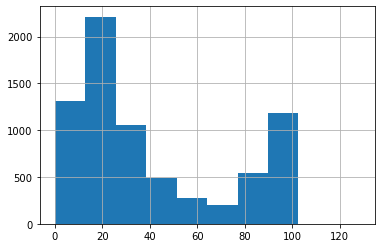

In [38]:
accre.time_pct_used.hist()

In [39]:
accre.usedtime.describe()

count    7.274000e+03
mean     1.365410e+05
std      1.614047e+05
min      8.000000e+00
25%      2.747475e+04
50%      8.417800e+04
75%      1.757140e+05
max      1.522543e+06
Name: usedtime, dtype: float64

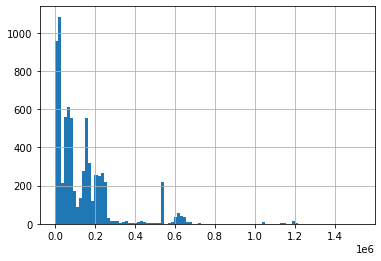

In [40]:
accre.usedtime.hist(bins = 100)

In [37]:
accre.head()

index     jobid  account      user  reqmemory  usedmemory  mem_diff  \
0      0  15925210  treviso  arabella     5120.0      2748.9    2371.1   
1      1  15861126  treviso  arabella     5120.0      2799.2    2320.8   
2      2  15861125  treviso  arabella     5120.0      2879.7    2240.3   
3      3  16251645  treviso  arabella     5120.0      2721.6    2398.4   
4      4  16251646  treviso  arabella     5120.0      2744.8    2375.2   

   mem_diff_pct  reqtime  usedtime  time_diff  time_diff_pct  nodes  cpus  \
0     53.689453  1188000   1188028        -28     100.002357      1    24   
1     54.671875  1188000   1090256      97744      91.772391      1    24   
2     56.244141  1188000   1188020        -20     100.001684      1    24   
3     53.156250  1188000   1050632     137368      88.437037      1    24   
4     53.609375  1188000   1188003         -3     100.000253      1    24   

    partition  exitcode_user  exitcode_node      state nodelist  
0  production              0              0  COMPLETED   cn1531  
1  production              0              0  COMPLETED   cn1441  
2  production              0              0  COMPLETED   cn1464  
3  production              0              0  COMPLETED   cn1473  
4  production              0              0  COMPLETED   cn1440

In [ ]:
#Create a column of each job's weighted percentage of memory use.
accre['weighted_mem'] = accre['mem_pct_used'] * accre['reqtime'] / accre['reqtime'].sum()

#Group weighted averages and find mean per account.
accre[accre['state']!='FAILED'].groupby(
    'account')[['account', 'weighted_mem']].mean().sort_values('weighted_mem').head(10)

In [43]:
accre[['reqtime', 'mem_pct_used', 'weighted_mem']] .sort_values('mem_pct_used').iloc[3200000:3200010]

KeyError: "['weighted_mem'] not in index"

In [34]:
#accre[['exitcode_user', 'exitcode_node']] = accre['exitcode'].str.split(':', expand=True).astype(int)

In [28]:
accre[accre['state']!='COMPLETED']['state'].value_counts()

CANCELLED    13
FAILED        2
Name: state, dtype: int64

### Slice off to create dataframe with records only related to node failures.
MP shared code on 10/3 

In [19]:
#accre[['exitcode_user', 'exitcode_node']] = accre['exitcode'].str.split(':', expand=True).astype(int)
#new DF only including records with node failures. 
#accre_node_failure = accre.loc[accre['exitcode_node'] != 0]

In [19]:
accre.state.nunique()

1

In [20]:
accre.state.unique()

array(['COMPLETED'], dtype=object)

In [21]:
accre.NODES.nunique()

94

In [22]:
accre.NODES.value_counts()

1     3745514
1       65391
2        2459
3         861
4         579
       ...   
51          1
44          1
43          1
41          1
61          1
Name: NODES, Length: 94, dtype: int64

In [34]:
accre[accre.NODES==1].nunique()

JOBID        3745514
ACCOUNT          172
USER             594
REQMEM           204
USEDMEM       827081
REQTIME          448
USEDTIME      161540
NODES              1
CPUS              23
PARTITION         15
EXITCODE          24
STATE             33
NODELIST         868
dtype: int64

In [36]:
accre[(accre.STATE=='FAILED')|(accre.STATE=='OUT_OF_MEMORY')].shape

(1500, 13)

## Scraps 
To be deleted/saved elsewhere

In [108]:


#pd.to_datetime returned error Unknown string format 13-18:00:00.  Replace the - with :

#accre['reqtime'] = accre['reqtime'].str.replace('-',':')
#accre['usedtime'] = accre['usedtime'].str.replace('-',':')

#create a placeholder column in order to view the original and updated values side by side
#accre['reqtime2'] = accre['reqtime']

#accre['reqtime2'] = pd.to_timedelta(accre['reqtime2'])

#Write & test if/else portion of formula. IF the string value in the column is shorter than 9 characters, then it means there is no hour data.
#Fill in the hour value by appending '0-' on the left of the string. This will make all our strings able to parse into an equal number of substrings.

#time = '1-22:16:15'

#if len(time) <9:
    #time = "0-" + time
#else: time

#Use regex to select either '-' OR ':' as delimiter for split
#Cast substring to numeric, turning it into an array. Cleaner to do it here than for each individual substring

#substring = pd.to_numeric(re.split('[-|:]',time))
#substring

#Separate each element of the array and save to variable representing unit of time
#Add the product of each variable and the multiplier to get the total time in seconds

#day = substring[-4]
#hours = substring[-3]
#minutes = substring[-2]
#seconds = substring[-1]

#time_in_seconds= day*86400 + hours*3600 + minutes*60 + seconds


#sample_df = {'job':['1','2','3','4','5'],'reqtime_test':['23:58:00','2-10:58:00','2-00:00:00','22:18:36','4-02:50:00'],'usedtime_test':['22:19:15','1-23:58:00','1-05:17:04','20:52:47','4-02:50:01']}
#sample_df = pd.DataFrame(sample_df,columns=['job','reqtime_test','usedtime_test'])
#sample_df

#sample_df['reqtime_seconds'] = sample_df['reqtime_test'].apply(convert_time_to_seconds)

#sample_df

#Define time_in_seconds()

#def convert_time_to_seconds(time):
    #"""Return an integer value of the time converted into seconds."""
    
    #Identify values not formatted as dhhmmss. Fill in the hour value by appending '0-' on the left of the string. 
    #This will make all our strings able to parse into an equal number of substrings.
    
    #if len(time) <9:
        #time = "0-" + time
   # else: time
    
    #Use regex to select either '-' OR ':' as delimiter for split
    #Cast the list of substrings to numeric, turning it into an array. Cleaner to do it here than for each individual substring
    #time = pd.to_numeric(re.split('[-|:]',time))

    #Separate each element of the array and save to variable representing unit of time
    #day = time[-4]
    #hours = time[-3]
    #minutes = time[-2]
    #seconds = time[-1]

    #Add the product of each unit and it's multiplier to get the total time in seconds
    #time_in_seconds= day*86400 + hours*3600 + minutes*60 + seconds
    
    #return time_in_seconds